In [1]:
from augmented_modules import ResnetBlock, CondInstanceNorm, TwoInputSequential, CINResnetBlock, InstanceNorm2d
from augmented_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'On {device}')
Tensor  = torch.cuda.FloatTensor


Figure directory exists.
On cuda:0


In [2]:
#for quicker debugging purposes
# class CustomDataset(Dataset):
#     def __init__(self, num_samples):
#         # Generate synthetic data (you can replace this with your actual data)
#         self.data1 = torch.randn(num_samples, 3, 224, 224)
#         self.data2 = torch.randn(num_samples, 3, 224, 224)
#         self.labels1 = torch.arange(num_samples)  # Dummy labels (you can modify this)
#         self.labels2 = torch.arange(num_samples)

#     def __len__(self):
#         return len(self.data1)

#     def __getitem__(self, idx):
#         sample = {
#               'D img': self.data1[idx],
#               'D pm' : self.labels1[idx],
#               'L img': self.data2[idx],
#               'L pm' : self.labels2[idx]
#         }
#         return sample

# # Create an instance of your custom dataset
 # Adjust as needed
custom_dataset = CyDataset()
 #CustomDataset(num_samples = 3000 ) #
# Create a DataLoader
batch_size = 2
train, val = train_test_split(custom_dataset, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val, batch_size=1, shuffle=True)

In [3]:
import subprocess

def get_gpu_info():
    try:
        output = subprocess.check_output(['nvidia-smi', '--query-gpu=utilization.gpu,memory.total,memory.used,memory.free', '--format=csv,noheader,nounits'])
        output = output.decode('utf-8').strip().split('\n')
        gpu_info = []
        for line in output:
            gpu_util, memory_total, memory_used, memory_free = map(int, line.split(','))
            gpu_info.append({
                'gpu_utilization': gpu_util,
                'memory_total': memory_total,
                'memory_used': memory_used,
                'memory_free': memory_free
            })
        return gpu_info
    except subprocess.CalledProcessError:
        return None

# Example usage:
gpu_info = get_gpu_info()
if gpu_info is not None:
    for i, gpu in enumerate(gpu_info):
        print(f"GPU {i}:")
        print(f"  Utilization: {gpu['gpu_utilization']} %")
        print(f"  Memory Total: {gpu['memory_total']} MB")
        print(f"  Memory Used: {gpu['memory_used']} MB")
        print(f"  Memory Free: {gpu['memory_free']} MB")
else:
    print("Error occurred while fetching GPU info.")


GPU 0:
  Utilization: 0 %
  Memory Total: 11264 MB
  Memory Used: 5 MB
  Memory Free: 10833 MB


In [4]:
# norm_layer_ = functools.partial(nn.InstanceNorm2d, affine=False)
# mod = Latent_Encoder(nlatent=3, input_nc=3, nef=32, norm_layer=norm_layer_)
# ex = torch.rand((5,3,224,224))

# g = mod(ex)

In [5]:
class Pixel_Level_Augmented_CycleGAN():
    def __init__(self):
        super(Pixel_Level_Augmented_CycleGAN,self).__init__()
        
        norm_layer_C = CondInstanceNorm
        norm_layer_ = functools.partial(nn.InstanceNorm2d, affine=False)
        
        self.G_ST = CINResnetGenerator(nlatent=16, input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer_C,
                 use_dropout=False, n_blocks=3, gpu_ids=[], padding_type='reflect')
        
        self.G_TS = CINResnetGenerator(nlatent=16, input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer_C,
                 use_dropout=False, n_blocks=3, gpu_ids=[], padding_type='reflect')

        self.D_T = NLayerDiscriminator(input_nc=3, ndf=64, n_layers=4, norm_layer=norm_layer_)
        self.D_S = NLayerDiscriminator(input_nc=3, ndf=64, n_layers=4, norm_layer=norm_layer_)

        self.D_Zs = Discriminator_Latent(nlatent=16, ndf=64)
        self.D_Zt = Discriminator_Latent(nlatent=16, ndf=64)
        
        self.E_S = Latent_Encoder(nlatent=16, input_nc=6, nef=32, norm_layer=norm_layer_)
        self.E_T = Latent_Encoder(nlatent=16, input_nc=6, nef=32, norm_layer=norm_layer_)

        self.G_ST.to(device)
        self.G_TS.to(device)
        self.E_S.to(device)
        self.E_T.to(device)
        self.D_S.to(device)
        self.D_T.to(device)
        self.D_Zs.to(device)
        self.D_Zt.to(device)

        self.ganloss = GANLoss().to(device)       
        self.cycleloss = torch.nn.L1Loss().to(device)               #difference between reconstructed img and original
        self.identityloss = torch.nn.L1Loss().to(device)
        
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.G_ST.parameters(), self.G_TS.parameters()), 
                                            lr=2e-5, betas=(0.5,0.999))
  
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.D_S.parameters(),self.D_T.parameters())
                                             , lr = 1e-5, betas = (0.5,0.9))
    
        self.optimizer_DZ = torch.optim.Adam(itertools.chain(self.D_Zs.parameters(),self.D_Zt.parameters())
                                             , lr = 1e-5, betas = (0.5,0.9))
        
        self.optimizer_E = torch.optim.Adam(itertools.chain(self.E_S.parameters(),self.E_T.parameters())
                                             , lr = 1e-5, betas = (0.5,0.9))
        


        self.G_ST.apply(weights_init_normal)
        self.G_TS.apply(weights_init_normal)
        self.D_S.apply(weights_init_normal)
        self.D_T.apply(weights_init_normal)

        print('initialized')
    def sample_images(self, dataloader, epochs, iters, save = False):
        
        batch = next(iter(dataloader))
        
        self.data_input(batch)
        self.G_ST.eval()
        self.G_TS.eval()
        
        self.forward_pass()

        real_S = make_grid(self.real_S, nrow=5, normalize=True, scale_each=True, padding=1)
        fake_T = make_grid(self.t_tilde, nrow=5, normalize=True, scale_each=True, padding=1)
        reconS = make_grid(self.s_prime, nrow=5, normalize=True, scale_each=True, padding=1)
        real_T = make_grid(self.real_T, nrow=5, normalize=True, scale_each=True, padding=1)
        fake_S = make_grid(self.s_tilde, nrow=5, normalize=True, scale_each=True, padding=1)
        reconT = make_grid(self.t_prime, nrow=5, normalize=True, scale_each=True, padding=1)
        # Arange images along y-axis    
        image_grid = torch.cat((real_S, fake_T, reconS, real_T, fake_S, reconT), 2)
        plt.imshow(image_grid.cpu().permute(1,2,0))
        plt.title('Real Source | Fake Target | Recon Source || Real Target | Fake Source | Recon Target')
        plt.axis('off')
        plt.gcf().set_size_inches(10, 6)
        if save:
            plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
        plt.show()
        plt.close()
        
    def data_input(self, batch):
        self.real_S = batch['D img'].type(Tensor)
        self.real_T = batch['L img'].type(Tensor)
        self.real_lbl = batch['D pm'].type(Tensor).float()
        
        self.prior_S = self.real_S.data.new(self.real_S.size(0), 16, 1, 1).normal_(0, 1)
        self.prior_T = self.real_T.data.new(self.real_T.size(0), 16, 1, 1).normal_(0, 1)
                  
    def forward_pass(self):
        #S--->T forward pass
        self.t_tilde = self.G_ST(self.real_S, self.prior_T) #shape checks out [BS, CH, H, W] ~ [5, 3, 224, 224] 
        self.s_mu, self.s_logvar = self.E_S(torch.cat((self.t_tilde, self.real_S), 1))
        self.zeta_tilde_s = reparameterize(self.s_mu, self.s_logvar)
        self.s_prime = self.G_TS(self.t_tilde, self.zeta_tilde_s)
        self.zs_mu, self.zs_logvar = self.E_T(torch.cat((self.real_S, self.t_tilde),1))
        self.zeta_t_prime = reparameterize(self.zs_mu, self.zs_logvar)

        
        #T--->S forward pass
        self.s_tilde = self.G_TS(self.real_T, self.prior_S) #shape checks out [BS, CH, H, W] ~ [5, 3, 224, 224] 
        self.t_mu, self.t_logvar= self.E_T(torch.cat((self.s_tilde,self.real_T),1))
        self.zeta_tilde_t = reparameterize(self.t_mu, self.t_logvar)
        self.t_prime = self.G_TS(self.s_tilde, self.zeta_tilde_t)
        self.zt_mu, self.zt_logvar = self.E_S(torch.cat((self.real_T, self.s_tilde),1))
        self.zeta_s_prime = reparameterize(self.zt_mu, self.zt_logvar)
        
        
    def backward_D(self, netD, real, fake):
         
        # Real
        pred_real = netD(real)
        loss_D_real = self.ganloss(pred_real, True)
        
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.ganloss(pred_fake, False)

        loss_D = (loss_D_real + loss_D_fake) * 0.5

        return loss_D
    
    def backward_Discriminators(self): 
        self.loss_DS = self.backward_D(self.D_S, self.real_S, self.t_tilde.detach())
        self.loss_DT = self.backward_D(self.D_T, self.real_T, self.s_tilde.detach())
        
        self.loss_DZs = self.backward_D(self.D_Zs, self.prior_S, self.zeta_tilde_s.detach())  #log(D_zs(zs) + log(1-(D_zs(E_s(S, G_ST(S, z_t))))))
        self.loss_DZt = self.backward_D(self.D_Zt, self.prior_T, self.zeta_tilde_t.detach())  #log(D_zt(zt) + log(1-(D_zt(E_t(T, G_TS(T, z_s))))))

        self.loss_D = self.loss_DS + self.loss_DT +self.loss_DZs +self.loss_DZt
        
        self.loss_D.backward()
        
        
    def backward_Generators(self):
        
        #NEED TO ADD ADVERSARIAL TRICK HERE (done)
        self.loss_G_S = self.ganloss(self.D_S(self.t_tilde), True)       #L(D_S(G_ST(S)))
        self.loss_G_T = self.ganloss(self.D_T(self.s_tilde), True)       #L(D_T(G_TS(T)))   
        
        
        #POTENTIALLY ADD IDENTITY LOSS?
#         self.idt_S = self.G_ST(self.real_T)  #G_ST(t) ~ s  ~t           ***t_tilde
#         self. idt_T = self.G_TS(self.real_S)  #G_TS(G_ST(s))          ***s_tilde
        
        self.loss_idt_S = self.identityloss(self.t_tilde, self.real_T) * 10 * 0.5
        self.loss_idt_T = self.identityloss(self.s_tilde, self.real_S) * 10 * 0.5
        
        self.L_cyc_s = self.cycleloss(self.s_prime, self.real_S)  #|| G_TS(G_ST(S,zt), E_S(S,zeta_tilde_t))||1
        self.L_cyc_t = self.cycleloss(self.t_prime, self.real_T)  #|| G_ST(G_TS(T,zs), E_T(T,zeta_tilde_s))||1
        
    
        self.L_cyc_zt = self.cycleloss(self.zeta_t_prime, self.prior_T)
        self.L_cyc_zs = self.cycleloss(self.zeta_s_prime, self.prior_S)
        
        
        #HYPER-PARAMETERS NEEDED FOR LCYCS AND LCYCT
        self.loss_G = self.loss_G_S + self.loss_G_T+ self.L_cyc_s+ self.L_cyc_t + self.L_cyc_zt + self.L_cyc_zs + self.loss_idt_S + self.loss_idt_T
        self.loss_G.backward()
        
    def optimize(self):
        self.forward_pass()
####---------------------------------------####
# Train Discriminators D_S, D_T, D_Zs, D_Zt   #
####---------------------------------------####
        set_requires_grad([self.D_S, self.D_T, self.D_Zs, self.D_Zt], requires_grad=True)
        set_requires_grad([self.G_ST, self.G_TS, self.E_T, self.E_S], requires_grad=False)
        self.optimizer_D.zero_grad()
        self.optimizer_DZ.zero_grad()
        
        self.backward_Discriminators()
        
        self.optimizer_D.step()
        self.optimizer_DZ.step()
        
        
# ####------------------------------------------------####
# # Train Generators and Encoders G_ST, G_TS, E_S, E_T   #
# ####------------------------------------------------####
        set_requires_grad([self.D_S, self.D_T, self.D_Zs, self.D_Zt], requires_grad=False)
        set_requires_grad([self.G_ST, self.G_TS, self.E_T, self.E_S], requires_grad=True)
        self.optimizer_G.zero_grad()
        self.optimizer_E.zero_grad()
        
        self.backward_Generators()
        
        self.optimizer_G.step()
        self.optimizer_E.step()
        
        return self.loss_G, self.loss_D, self.D_S, self.D_T, self.D_Zs, self.D_Zt, self.G_ST, self.G_TS, self.E_T, self.E_S
        


initialized


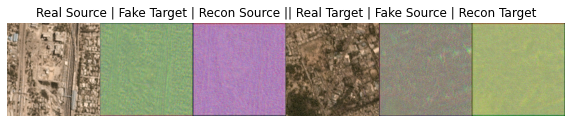

Iteration 100/12590 finished at 16:30:25.143319
                [G Loss: 9.68316650390625]	[D Loss: 2.4127917289733887]



KeyboardInterrupt: 

In [6]:
history = {'epoch':[],'G_loss': [], 'D_loss':[], 'batch':[]}
torch.cuda.empty_cache()

model = Pixel_Level_Augmented_CycleGAN()
best_g_loss = 1e6
best_d_loss = 1e6

n_epochs = 15

for e in range(n_epochs):
    for i, batch in tqdm(enumerate(train_dataloader)):
        model.data_input(batch)
        torch.cuda.empty_cache()
        G_loss, D_loss, D_S, D_T, D_Zs, D_Zt, G_ST, G_TS, E_T, E_S = model.optimize()
            
        if D_loss < best_d_loss:
            best_d_loss = D_loss
            torch.save({'D_T': D_T.state_dict(), 'D_S': D_S.state_dict(), 'D_Zs': D_Zs.state_dict(), 'D_Zt': D_Zt.state_dict()}, 'best_d.pt')
            
        if G_loss < best_g_loss:
            best_g_loss = G_loss
            torch.save({ 'G_ST': G_ST.state_dict(),'G_TS': G_TS.state_dict(), 'E_S':E_S.state_dict(), 'E_T':E_T.state_dict()}, 'best_g.pt')
            
        
        if (i+1) % 100 == 0:
            with torch.no_grad():
                now = datetime.datetime.now()
                model.sample_images(val_dataloader, e, i, save=False)
                print(f"Iteration {i + 1}/{len(train_dataloader)} finished at {now.time()}\n\
                [G Loss: {G_loss.item()}]\t[D Loss: {D_loss.item()}]")
   
            history['G_loss'].append(G_loss.item())
            history['D_loss'].append(D_loss.item())
            history['batch'].append(i+1)
            history['epoch'].append(e+1)
      